# Build an implied volatility surface with Python

A volatility surface plots the level of implied volatility in 3D space. The days to expiration are on the X-axis, the strike price is on the Y-axis, and implied volatility is on the Z-axis.

Implied volatility is the market’s expectations of volatility over the life of an option. To find implied volatility you need three things: the market price of the option, a pricing model, and a root finder. You can then find the volatility that sets the price from the model equal to the price of the market with the root finder. “The volatility implied by the market.” The volatility surface is found by repeating this for all options and plotting the results.

You can use the implied volatility from Yahoo Finance. In practice, traders calculate it themselves.

Pricing models assume volatility is the same for all strike prices and maturities. Volatility surfaces show this assumption is not true. Volatility has skew (volatility is different across strike prices) and a term structure (volatility is different across maturities). Quants use volatility surfaces to help calibrate models and price OTC derivatives that don’t trade on exchanges.

Volatility surfaces prove the models wrong.

When you value an option, the variables in the model (e.g. stock price, time to expiration) are known except volatility, which is an estimate. If models were completely correct, the volatility surface across strike prices and maturities would be flat. In practice. This is not the case as you’ll see.

- Get live options data
- Analyze volatility skew
- Analyze volatility structure
- Build an implied volatility surface


In [2]:
# Step 1: Get live options data

# Start by importing the libraries you need. I use yfinance to get options data for free.

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt

import matplotlib.pyplot as plt

# yfinance returns data for all strikes for a single expiration at a time. It’s easier to work with all strikes and expirations at the same time so write a function to combine the expirations.

def option_chains(ticker):
    """
    """
    asset = yf.Ticker(ticker)
    expirations = asset.options

    chains = pd.DataFrame()

    for expiration in expirations:
        # tuple of two dataframes
        opt = asset.option_chain(expiration)

        calls = opt.calls
        calls['optionType'] = "call"

        puts = opt.puts
        puts['optionType'] = "put"

        chain = pd.concat([calls, puts])
        chain['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)

        chains = pd.concat([chains, chain])

    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1

    return chains

# This function first gets all the expirations. Then it loops through each expiration and gets the option chain. It adds a column for option type, changes the expiration date to be at the end of the day, the combines each option chain together in a DataFrame. Finally, it computes the number of days until expiration.

<AxesSubplot:title={'center':'Implied Volatility Skew'}, xlabel='strike'>

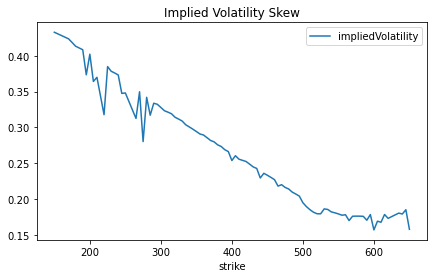

In [6]:
# Step 2: Analyze skew and term structure

# yfinance provides an estimate of implied volatility so you don’t have to compute it. This is ok for a quick analysis. In practice, quants derive their own implied volatility using custom models.

# Start by downloading the data and getting the call options. The options data are in a pandas DataFrame which makes it easy.

options = option_chains("SPY")

calls = options[options["optionType"] == "call"]
# Next, pick an expiration so you can plot the volatility skew.

# print the expirations
set(calls.expiration)

# select an expiration to plot
calls_at_expiry = calls[calls["expiration"] == "2025-12-19 23:59:59"]

# filter out low vols
filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.impliedVolatility >= 0.001]

# set the strike as the index so pandas plots nicely
filtered_calls_at_expiry[["strike", "impliedVolatility"]].set_index("strike").plot(
    title="Implied Volatility Skew", figsize=(7, 4)
)

In [5]:
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expiration,daysToExpiration
0,SPY230501C00330000,2023-04-27 14:10:09+00:00,330.0,77.80,85.89,86.47,0.0,0.000000,1.0,1.0,1.476565,True,REGULAR,USD,call,2023-05-01 23:59:59,2
1,SPY230501C00350000,2023-04-18 16:55:10+00:00,350.0,64.53,65.89,66.47,0.0,0.000000,NaN,1.0,1.145512,True,REGULAR,USD,call,2023-05-01 23:59:59,2
2,SPY230501C00357000,2023-04-20 15:12:58+00:00,357.0,55.95,58.90,59.48,0.0,0.000000,NaN,0.0,1.038091,True,REGULAR,USD,call,2023-05-01 23:59:59,2
3,SPY230501C00360000,2023-04-17 13:42:02+00:00,360.0,53.40,55.90,56.47,0.0,0.000000,NaN,3.0,0.986328,True,REGULAR,USD,call,2023-05-01 23:59:59,2
4,SPY230501C00370000,2023-04-24 15:38:02+00:00,370.0,41.62,45.90,46.48,0.0,0.000000,NaN,1.0,0.828127,True,REGULAR,USD,call,2023-05-01 23:59:59,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,SPY251219C00630000,2023-04-12 14:36:06+00:00,630.0,2.56,0.00,5.00,0.0,0.000000,4.0,5.0,0.177971,False,REGULAR,USD,call,2025-12-19 23:59:59,965
93,SPY251219C00635000,2023-04-26 13:30:05+00:00,635.0,2.94,1.03,5.00,0.0,0.000000,1.0,7.0,0.180382,False,REGULAR,USD,call,2025-12-19 23:59:59,965
94,SPY251219C00640000,2023-04-27 20:10:17+00:00,640.0,1.72,0.01,4.59,0.0,0.000000,2.0,6.0,0.179162,False,REGULAR,USD,call,2025-12-19 23:59:59,965
95,SPY251219C00645000,2023-04-21 19:49:01+00:00,645.0,1.98,1.52,5.00,0.0,0.000000,1.0,21.0,0.185128,False,REGULAR,USD,call,2025-12-19 23:59:59,965


<AxesSubplot:title={'center':'Implied Volatility Term Structure'}, xlabel='expiration'>

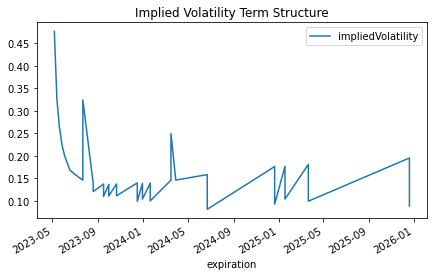

In [7]:
# Notice two things. First, the data are messy. In practice, quants use their own models to calculate implied volatility. They also filter out outliers and use smoothing algorithms. The second thing to notice is that the implied volatility varies with each strike. In particular, it is lowest at the $500 strike, which is right around the stock price. This is known as volatility smile.

# Next, build a volatility term structure. Pick a strike price to plot by expiration.

# select an expiration to plot
calls_at_strike = options[options["strike"] == 500.0]

# filter out low vols
filtered_calls_at_strike = calls_at_strike[calls_at_strike.impliedVolatility >= 0.001]

# set the strike as the index so pandas plots nicely
filtered_calls_at_strike[["expiration", "impliedVolatility"]].set_index("expiration").plot(
    title="Implied Volatility Term Structure", figsize=(7, 4)
)

Implied volatility is decreasing as the expiration dates get further out. This tells you the market expectation of volatility is lower in the future than it is today. You’ll often see spikes in the term structure when big economic news is scheduled. The effect is caused by traders bidding up the prices of options in expectation of market swings.

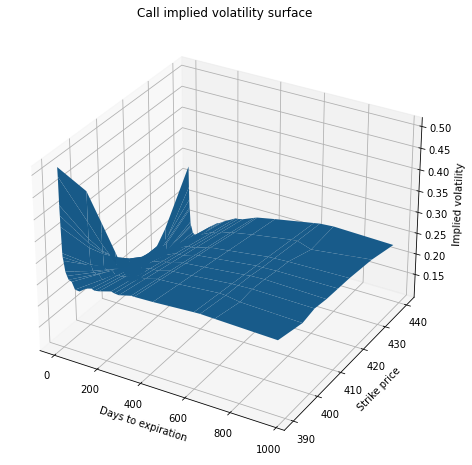

In [8]:
# Step 3: Plot a volatility surface

# By putting both charts together, you get the volatility surface. In derivatives pricing and trading, volatility surfaces are very important. Quants use the surface to price and trade other more exotic derivatives and look for market mispricings. Volatility surfaces are also used to determine profit and loss by “marking trades to model.”

# pivot the dataframe
surface = (
    calls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
    .dropna()
)

# create the figure object
fig = plt.figure(figsize=(10, 8))

# add the subplot with projection argument
ax = fig.add_subplot(111, projection='3d')

# get the 1d values from the pivoted dataframe
x, y, z = surface.columns.values, surface.index.values, surface.values

# return coordinate matrices from coordinate vectors
X, Y = np.meshgrid(x, y)

# set labels
ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied volatility')
ax.set_title('Call implied volatility surface')

# plot
ax.plot_surface(X, Y, z)